In [53]:
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
from torchvision import transforms
from pathlib import Path
import timm


# --- 1. Cargar el Modelo y Preparar las Transformaciones ---
print("Cargando el modelo DINOv2 (dinov2_vit14)...")
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dinov2.to(device)
dinov2.eval() # Poner el modelo en modo de evaluación
print(f"Modelo cargado en: {device}")

transform_image = transforms.Compose([
    transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

Cargando el modelo DINOv2 (dinov2_vit14)...


Using cache found in C:\Users\sergi/.cache\torch\hub\facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to C:\Users\sergi/.cache\torch\hub\checkpoints\dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:31<00:00, 10.9MB/s] 


Modelo cargado en: cuda


In [15]:
def get_image_embedding(image_path):
    """Procesa una imagen y devuelve su embedding global [CLS]."""
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform_image(img).unsqueeze(0).to(device)
    with torch.no_grad():
        # DINOv2 devuelve tanto el token [CLS] como los tokens de parche.
        # Para la semántica global, usamos el [CLS] que es el primero.
        features = dinov2(img_tensor)
        cls_embedding = features[0] # Shape: [1, 384]
    return cls_embedding.cpu().numpy()


In [55]:

# --- 2. Sistema de Comparación Semántica ---
def run_semantic_search(gallery_folder, query_image_path):
    print("\n--- Ejecutando Búsqueda Semántica ---")
    
    # Asegúrate de que esta carpeta exista y tenga imágenes
    gallery_image_paths = [
        str(Path(gallery_folder) / f)
        for f in os.listdir(gallery_folder)
        if f.lower().endswith(('jpg', 'png', 'jpeg'))
    ]

    # Obtener Embeddings de la imagen query
    query_embedding = get_image_embedding(query_image_path)
    
    best_match_path = None
    highest_similarity = -1

    for path in gallery_image_paths:
        # No comparar una imagen consigo misma
        if Path(path).resolve() == Path(query_image_path).resolve():
            continue
            
        gallery_embedding = get_image_embedding(path)
        query_embedding = query_embedding.reshape(1, -1)
        gallery_embedding = gallery_embedding.reshape(1, -1)
        similarity = cosine_similarity(query_embedding, gallery_embedding)[0][0]
        
        print(f"Comparando con '{os.path.basename(path)}'... Similitud Coseno: {similarity:.4f}")
        
        if similarity > highest_similarity:
            highest_similarity = similarity
            best_match_path = path

    print("\n--- Resultado ---")
    print(f"La imagen de consulta es: '{os.path.basename(query_image_path)}'")
    if best_match_path:
        print(f"La imagen más similar semánticamente es: '{os.path.basename(best_match_path)}' con una puntuación de {highest_similarity:.4f}")
    else:
        print("No se encontraron otras imágenes para comparar.")


run_semantic_search( "../data/imgs", '../data/imgs/img_0.jpg')



--- Ejecutando Búsqueda Semántica ---
Comparando con 'img_1.png'... Similitud Coseno: 0.0032
Comparando con 'img_10.png'... Similitud Coseno: 0.0758
Comparando con 'img_11.png'... Similitud Coseno: 0.1027
Comparando con 'img_12.png'... Similitud Coseno: -0.0206
Comparando con 'img_2.jpg'... Similitud Coseno: 0.0302
Comparando con 'img_3.jpg'... Similitud Coseno: 0.3192
Comparando con 'img_4.jpg'... Similitud Coseno: 0.2721
Comparando con 'img_5.png'... Similitud Coseno: 0.0921
Comparando con 'img_6.png'... Similitud Coseno: 0.0625
Comparando con 'img_7.png'... Similitud Coseno: 0.0202
Comparando con 'img_8.png'... Similitud Coseno: 0.1009
Comparando con 'img_9.png'... Similitud Coseno: 0.0237

--- Resultado ---
La imagen de consulta es: 'img_0.jpg'
La imagen más similar semánticamente es: 'img_3.jpg' con una puntuación de 0.3192



--- Visualizando Embedding de un Parche ---
image shape (384,)


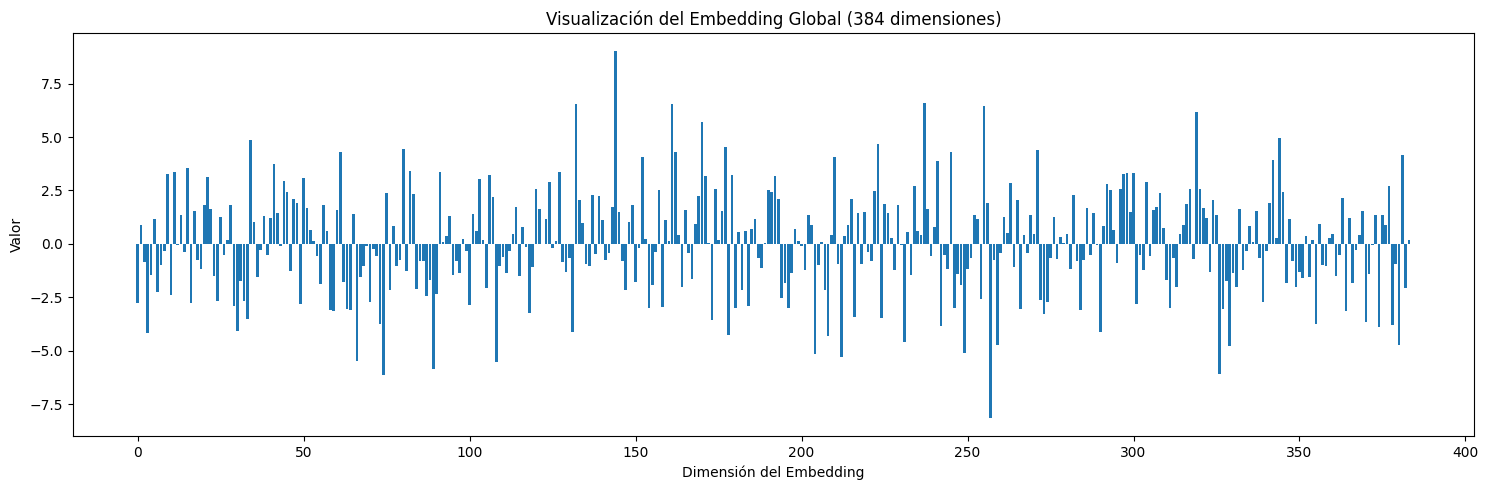

In [26]:
# --- 3. Visualización de Embedding de un Parche (Gráfico de Barras) ---
def run_embedding_visualization(image_path):
    print("\n--- Visualizando Embedding de un Parche ---")
    # Nota: Visualizar un vector de 384 dimensiones como barras no es muy informativo,
    # pero sirve para ver la "firma" numérica de un parche.
    img_embedding = get_image_embedding(image_path)
    print(f'image shape {img_embedding.shape}')
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(img_embedding)), img_embedding)
    plt.title("Visualización del Embedding Global (384 dimensiones)")
    plt.xlabel("Dimensión del Embedding")
    plt.ylabel("Valor")
    plt.tight_layout()
    plt.show()


run_embedding_visualization('../data/imgs/img_1.png')

In [47]:
# Asumo que las celdas anteriores con el modelo, las transformaciones, etc., ya se han ejecutado.

# --- 4. Visualización de Mapas de Atención (VERSIÓN FINAL CON MONKEY-PATCHING) ---

# Variable global para almacenar la salida
attention_store = None

def run_attention_map_visualization(image_path):
    print("\n--- Visualizando Mapa de Atención (con Monkey-Patching) ---")
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform_image(img).unsqueeze(0).to(device)

    # La capa que nos interesa sigue siendo la misma
    target_layer = dinov2.blocks[-1].attn

    # 1. Guardar el método 'forward' original de la capa
    original_forward = target_layer.forward

    # 2. Definir un nuevo método 'forward' que actúe como un espía
    def new_forward(x):
        global attention_store
        # Llama al método original para que la red funcione normalmente
        # El resultado es una tupla (features, attention_weights)
        output_tuple = original_forward(x)
        
        # Guardamos los pesos de atención (el segundo elemento) en nuestra variable
        attention_store = output_tuple[1]
        
        # Devolvemos solo el primer elemento, para que el resto de la red no se rompa
        return output_tuple[0]

    try:
        # 3. Reemplazar temporalmente el método 'forward' de la capa por el nuestro (Monkey-Patching)
        target_layer.forward = new_forward

        # 4. Ejecutar el forward pass. Esto llamará a nuestro 'new_forward' espía.
        with torch.no_grad():
            dinov2(img_tensor)

    finally:
        # 5. ¡MUY IMPORTANTE! Restaurar el método 'forward' original después de usarlo.
        # Esto asegura que dejamos el modelo en su estado original.
        target_layer.forward = original_forward

    # 6. Ahora, `attention_store` contiene los pesos que necesitamos, y podemos visualizarlos
    if attention_store is None:
        print("Error: No se pudieron capturar los pesos de atención.")
        return

    attentions = attention_store
    
    # El resto del código de visualización es el mismo
    cls_attention = attentions[0, :, 0, 1:].mean(dim=0)
    w_featmap = h_featmap = 16
    attention_map = cls_attention.reshape(w_featmap, h_featmap).cpu().numpy()
    
    resized_attention_map = transforms.ToPILImage()(attention_map)
    resized_attention_map = resized_attention_map.resize(img.size, Image.BICUBIC)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(resized_attention_map, cmap='jet', alpha=0.5)
    plt.title("Mapa de Atención (dónde 'mira' el modelo)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    plt.close()

# --- Llamada a la función ---
run_attention_map_visualization('../data/imgs/img_1.png')


--- Visualizando Mapa de Atención (con Monkey-Patching) ---


IndexError: index 1 is out of bounds for dimension 0 with size 1